# GOWelfare

#Import libraries


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import warnings
import scipy
import datetime
warnings.filterwarnings("ignore")

## Task 1 - Load the Datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
giftcard_model = pd.read_excel('/content/drive/MyDrive/Dataset/giftcards_models_202403221415.xlsx')
giftcard_obf = pd.read_excel('/content/drive/MyDrive/Dataset/giftcards_obfs.xlsx')
transaction = pd.read_excel('/content/drive/MyDrive/Dataset/transactions_obfs.xlsx')

## Task 2 - Analyzing the welfare data

### **Giftcard Model Dataset**


The `giftcard_model` dataset details the various giftcards available on the welfare application, along with their associated brands. Each giftcard entry includes the following information:

* **id:** A unique identifier for the gift card.
* **amount:** The monetary value of the gift card.
* **new_brand_name:** The updated name of the brand offering the gift card.
* **brand_id:** A unique identifier for the brand.
* **category:** The category to which the gift card belongs (e.g., groceries, electronics).
* **fee:** The margin or commission associated with the gift card.


First thing we see is that there are no NULL values and there are no duplicates. We also figure out the different data types of each column using 'info'.

In [4]:
giftcard_model.isnull().sum()

id                   0
amount               0
new_brand_name       0
brand_id             0
category             0
fee                  0
num_punti_vendita    0
dtype: int64

In [5]:
giftcard_model.duplicated().sum()

0

In [6]:
giftcard_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 96 non-null     int64  
 1   amount             96 non-null     int64  
 2   new_brand_name     96 non-null     object 
 3   brand_id           96 non-null     int64  
 4   category           96 non-null     object 
 5   fee                96 non-null     float64
 6   num_punti_vendita  96 non-null     int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 5.4+ KB


There are 96 different giftcard models with 34 different 'brand_id', meaning that each brand has multiple giftcard models

In [7]:
giftcard_model.nunique()

id                   96
amount               12
new_brand_name       33
brand_id             34
category              9
fee                  17
num_punti_vendita    32
dtype: int64

After that, we're interested in visualizing some distributions to understand which type of giftcards are usually provided by companies. In particular we find out that the most frequent giftcards have an amount of 50, 25 or 100 and that most of them belong to the 'food' category.

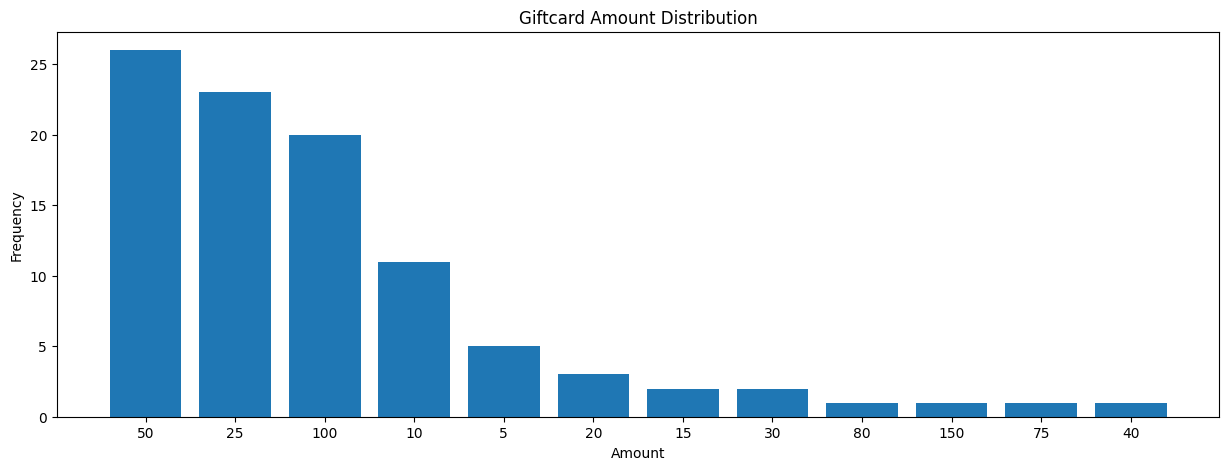

In [8]:
# We use a copy of the dataset in order to perform some changes we need to plot
models = giftcard_model

# Convert the 'amount' column to string type to make things easier for the barplot
models["amount"] = models["amount"].astype(str)

# Calculate the value counts of the 'amount' column
g_amount_count = models["amount"].value_counts()

# Plot the value counts
plt.figure(figsize=(15, 5))
plt.bar(g_amount_count.index, g_amount_count.values)

# Add titles and labels for better understanding
plt.title('Giftcard Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


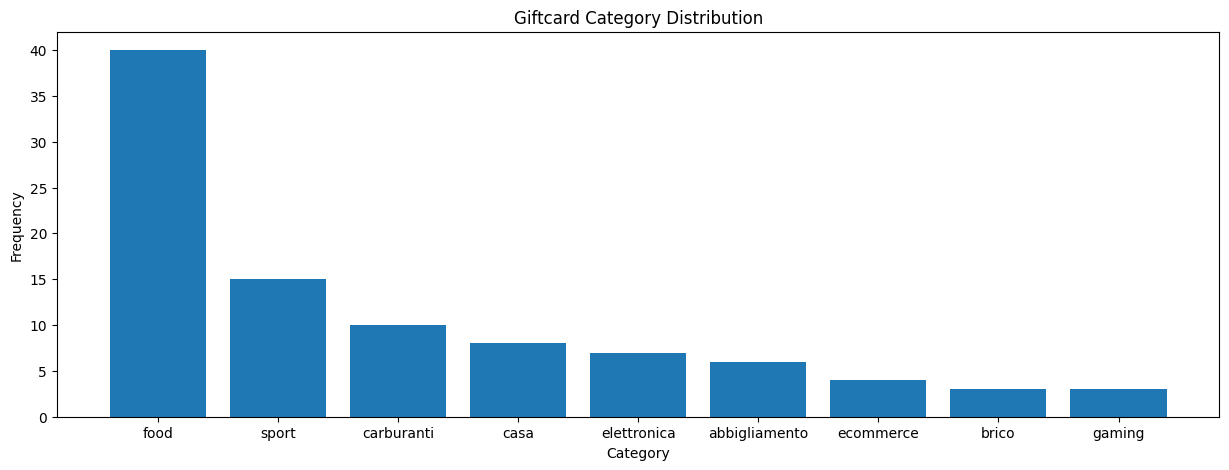

In [9]:
c_count = giftcard_model["category"].value_counts()

plt.figure(figsize=(15,5))
plt.bar(c_count.index, c_count.values)
plt.title('Giftcard Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

### **Giftcard Obf Dataset**


The `giftcard_obf` dataset lists all the giftcards bought by users, with the following columns:
- 'id'
- “provider_error_code”
- “purchase_date”
- “giftcard_model_id”
- “transaction_uuid_hash”
- “client_email_hash”.

The "id" refers to the type of giftcard that has been requested by client “client_email_hash".

In [10]:
giftcard_obf.head()

,id,provider_error_code,purchase_date,giftcard_model_id,transaction_uuid_hash,client_email_hash
0,75686,1011,2023-12-29 21:35:46.231 +0100,10,b3f52d237111dc6dfb811853400d8db9f917b714b33299...,1ea8ef90a29148dd72118dd7cf0b61ba61f60df96f32ad...
1,75693,1011,2023-12-29 21:36:48.652 +0100,10,11f1cbc0d73828c70e90551bd2e57b17ea004e0e81f712...,1ea8ef90a29148dd72118dd7cf0b61ba61f60df96f32ad...
2,75671,NaN,2023-12-29 21:32:26.388 +0100,34,bc66592b116d97c441ba3d8d3d1273595ecba9749f7d3d...,6e39242f217e06bd1e9fda8d54b56a75eb818d1b4dc302...
3,75667,NaN,2023-12-29 21:31:32.049 +0100,55,e0fd1487effe4744d49d0b0577ab9359584711d1a7526b...,1ed7e37c036d9073a71e0758a1888d3e4d476d895092c8...
4,75668,NaN,2023-12-29 21:31:48.609 +0100,55,88b9cea66a4b45239b63b56c7340b88a58b15285693eeb...,1ed7e37c036d9073a71e0758a1888d3e4d476d895092c8...


We check for NULL values and find out that these are 33988 for 'provider_error_code'. In particular they represent the transactions for which there was not an error code. We decide to fill these with "No error", just for completeness.

In [11]:
giftcard_obf.isnull().sum()

id                           0
provider_error_code      33988
purchase_date                0
giftcard_model_id            0
transaction_uuid_hash        0
client_email_hash            0
dtype: int64

In [12]:
giftcard_obf["provider_error_code"].fillna("No error", inplace=True)

In [13]:
giftcard_obf.nunique()

id                       40189
provider_error_code          8
purchase_date            40189
giftcard_model_id           94
transaction_uuid_hash    40189
client_email_hash         9053
dtype: int64

In [14]:
giftcard_obf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40189 entries, 0 to 40188
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     40189 non-null  int64 
 1   provider_error_code    40189 non-null  object
 2   purchase_date          40189 non-null  object
 3   giftcard_model_id      40189 non-null  int64 
 4   transaction_uuid_hash  40189 non-null  object
 5   client_email_hash      40189 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.8+ MB


The info method shows that the 'purchase_date' column has values with 'object' as type, to handle better the values the type of the column is converted to datetime.

In [15]:
giftcard_obf['purchase_date'] = pd.to_datetime(giftcard_obf['purchase_date'])
giftcard_obf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40189 entries, 0 to 40188
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype                    
---  ------                 --------------  -----                    
 0   id                     40189 non-null  int64                    
 1   provider_error_code    40189 non-null  object                   
 2   purchase_date          40189 non-null  datetime64[ns, UTC+01:00]
 3   giftcard_model_id      40189 non-null  int64                    
 4   transaction_uuid_hash  40189 non-null  object                   
 5   client_email_hash      40189 non-null  object                   
dtypes: datetime64[ns, UTC+01:00](1), int64(2), object(3)
memory usage: 1.8+ MB


The analysis we are going to perform on the dataset clearly suggests to consider only rows for which there has not been an error code. Additionally, since the tasks ask for different information for FY 2023 and 2024, we divide the dataset into *giftcards_obfs_2023* and *giftcards_obfs_2024*.

In [16]:
giftcard_obf = giftcard_obf[giftcard_obf["provider_error_code"]=="No error"]

In [17]:
giftcard_obf.nunique()

id                       33988
provider_error_code          1
purchase_date            33988
giftcard_model_id           94
transaction_uuid_hash    33988
client_email_hash         8979
dtype: int64

In [18]:
giftcard_obf_2023 = giftcard_obf[giftcard_obf['purchase_date'].dt.year == 2023]
giftcard_obf_2024 = giftcard_obf[giftcard_obf['purchase_date'].dt.year == 2024]

#### Plots

Here we give a look at the top 10 giftcard models bought by users in 2023 and in 2024.

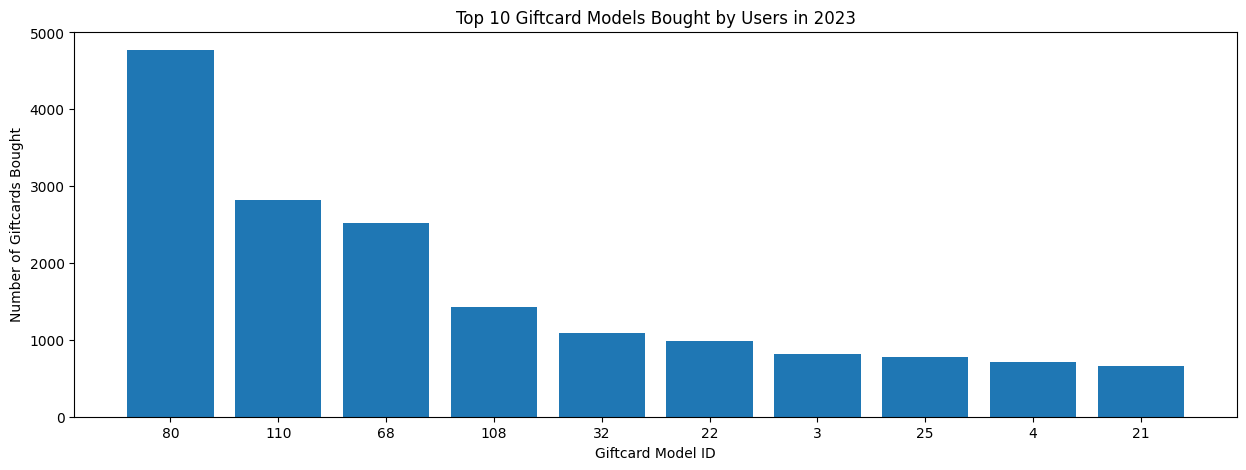

In [19]:
# Count each giftcard_model_id and get the top ten
top_ten_23 = giftcard_obf_2023["giftcard_model_id"].value_counts().head(10).reset_index()

# Rename columns for better readability
top_ten_23.columns = ["giftcard_model_id", "count"]

# Plot the data
plt.figure(figsize=(15, 5))
plt.bar(top_ten_23["giftcard_model_id"].astype(str), top_ten_23["count"])
plt.title('Top 10 Giftcard Models Bought by Users in 2023')
plt.xlabel('Giftcard Model ID')
plt.ylabel('Number of Giftcards Bought')
plt.show()

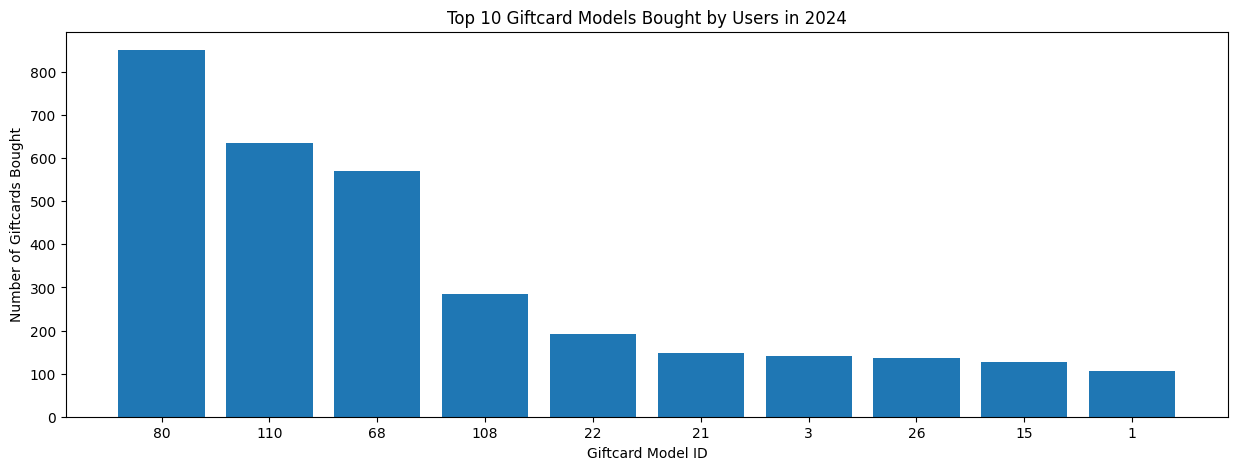

In [20]:
top_ten_24 = giftcard_obf_2024["giftcard_model_id"].value_counts().head(10).reset_index()
top_ten_24.columns = ["giftcard_model_id", "count"]

# Plot the data
plt.figure(figsize=(15, 5))
plt.bar(top_ten_24["giftcard_model_id"].astype(str), top_ten_24["count"])
plt.title('Top 10 Giftcard Models Bought by Users in 2024')
plt.xlabel('Giftcard Model ID')
plt.ylabel('Number of Giftcards Bought')
plt.show()

### **Transaction Dataset**


The `transaction` dataset lists all basic operations of the users towards the welfare platform. The columns are:
- “id”
- “amount”
- “type”
- “status”
- ”timestamp”
- “transaction_uuid_hash”
- “email_hash”
- "receiver_id_hash”.

There are no NULL values and no duplicates.

In [21]:
transaction.isnull().sum()

id                       0
amount                   0
type                     0
status                   0
timestamp                0
transaction_uuid_hash    0
email_hash               0
receiver_id_hash         0
dtype: int64

In [22]:
transaction.duplicated().sum()

0

We check how many values there are for 'type' and 'status' of the transactions and find out that they are all "topup"(new credit brought to the system) and the status is "confirm success".

In [23]:
transaction.nunique()

id                       18409
amount                     537
type                         1
status                       1
timestamp                18409
transaction_uuid_hash    18409
email_hash               15735
receiver_id_hash         15735
dtype: int64

In [24]:
transaction['type'].unique()

array(['topup'], dtype=object)

In [25]:
transaction['status'].unique()

array(['confirm_success'], dtype=object)

To figure out the different data types of each column we use the 'info'. The dataframe is composed by six object type and two numerical columns.

In [26]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18409 entries, 0 to 18408
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     18409 non-null  int64  
 1   amount                 18409 non-null  float64
 2   type                   18409 non-null  object 
 3   status                 18409 non-null  object 
 4   timestamp              18409 non-null  object 
 5   transaction_uuid_hash  18409 non-null  object 
 6   email_hash             18409 non-null  object 
 7   receiver_id_hash       18409 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.1+ MB


The info method shows that the 'timestamp' column has values with 'object' as type, to handle better the values the type of this column is converted to datetime.

In [27]:
transaction['timestamp'] = pd.to_datetime(transaction['timestamp'])
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18409 entries, 0 to 18408
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype                    
---  ------                 --------------  -----                    
 0   id                     18409 non-null  int64                    
 1   amount                 18409 non-null  float64                  
 2   type                   18409 non-null  object                   
 3   status                 18409 non-null  object                   
 4   timestamp              18409 non-null  datetime64[ns, UTC+01:00]
 5   transaction_uuid_hash  18409 non-null  object                   
 6   email_hash             18409 non-null  object                   
 7   receiver_id_hash       18409 non-null  object                   
dtypes: datetime64[ns, UTC+01:00](1), float64(1), int64(1), object(5)
memory usage: 1.1+ MB


Also for this dataset we distinguish between transactions made in 2023 and in 2024, even if transactions made in 2024 are very low.

In [28]:
transaction_2023 = transaction[transaction['timestamp'].dt.year == 2023]
transaction_2024 = transaction[transaction['timestamp'].dt.year == 2024]

In [29]:
print("Transactions made in 2024 represent",
      round((len(transaction_2024)/len(transaction))*100,2),
      "% of the total.")

Transactions made in 2024 represent 0.96 % of the total.


## The board of directors, at the end of December 2023, want to know, for the FY 2023:
- Total turnover (the sum of topups),
- Total spent (the sum of giftcards),
- Profits (the sum of margins/fees for each giftcards),
- Total unspent (the difference between the first and the second),
- Best performing brand and amount,
- Profits if all the giftcards had as fee the maximum among the fees.

###Total Turnover

In [30]:
total_turnover = round(transaction_2023["amount"].sum(),2)
print(f"The total turnover for the company is: {total_turnover}")

The total turnover for the company is: 2299656.39


###Total Spent

To calculate the total spent we need to sum the amount of the giftcards sold, so we need to merge the dataset `giftcard_obf` and `giftcard_model`. Before starting, we have to rename the column 'id' in the `giftcard_model` to avoid problems when performing the merge.

In [31]:
giftcard_model = giftcard_model.rename(columns={"id":"giftcard_model_id"})

In [32]:
giftcard_23 = giftcard_obf_2023.merge(giftcard_model)
giftcard_23.head()

,id,provider_error_code,purchase_date,giftcard_model_id,transaction_uuid_hash,client_email_hash,amount,new_brand_name,brand_id,category,fee,num_punti_vendita
0,75671,No error,2023-12-29 21:32:26.388000+01:00,34,bc66592b116d97c441ba3d8d3d1273595ecba9749f7d3d...,6e39242f217e06bd1e9fda8d54b56a75eb818d1b4dc302...,50,SportSuper,16,sport,0.042,992
1,75702,No error,2023-12-29 21:38:25.130000+01:00,34,1515f1c044f2919e3905e34d06ada4f2a8037d536708fc...,e83748693604c101abb0644b756146a3ce6a76abe2ee58...,50,SportSuper,16,sport,0.042,992
2,75708,No error,2023-12-29 21:40:52.055000+01:00,34,b7464aeb0624eac494194473d858a7e33dda0b581c37e6...,e83748693604c101abb0644b756146a3ce6a76abe2ee58...,50,SportSuper,16,sport,0.042,992
3,75716,No error,2023-12-29 21:44:10.852000+01:00,34,4e634c13d36c4bd746f9a6fa05d066df80c2b24426cf2a...,d9420e8f3b3ef66e6b1ddc47ddc602c3bba612b66af556...,50,SportSuper,16,sport,0.042,992
4,75851,No error,2023-12-30 00:27:06.529000+01:00,34,c000f46944823657098a60bb83cd4c8bd9d4b78078e763...,82e43e06125e6280025896ed09026f8c719c19f8ed5124...,50,SportSuper,16,sport,0.042,992


Through the 'info' method we notice that 'amount' in `giftcard_23` has values with 'object' as type, therefore, since we need to sum these values to get the Total Spent, we need them as 'int' type.



In [33]:
giftcard_23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype                    
---  ------                 --------------  -----                    
 0   id                     28821 non-null  int64                    
 1   provider_error_code    28821 non-null  object                   
 2   purchase_date          28821 non-null  datetime64[ns, UTC+01:00]
 3   giftcard_model_id      28821 non-null  int64                    
 4   transaction_uuid_hash  28821 non-null  object                   
 5   client_email_hash      28821 non-null  object                   
 6   amount                 28821 non-null  object                   
 7   new_brand_name         28821 non-null  object                   
 8   brand_id               28821 non-null  int64                    
 9   category               28821 non-null  object                   
 10  fee                    28821 non-null  float64

In [34]:
giftcard_23['amount'] = giftcard_23['amount'].astype(int)
giftcard_23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype                    
---  ------                 --------------  -----                    
 0   id                     28821 non-null  int64                    
 1   provider_error_code    28821 non-null  object                   
 2   purchase_date          28821 non-null  datetime64[ns, UTC+01:00]
 3   giftcard_model_id      28821 non-null  int64                    
 4   transaction_uuid_hash  28821 non-null  object                   
 5   client_email_hash      28821 non-null  object                   
 6   amount                 28821 non-null  int64                    
 7   new_brand_name         28821 non-null  object                   
 8   brand_id               28821 non-null  int64                    
 9   category               28821 non-null  object                   
 10  fee                    28821 non-null  float64

In [35]:
total_spent = giftcard_23["amount"].sum()
print(f"The total spent for the company is: {total_spent}")

The total spent for the company is: 1002055


###Total Profit



To determine the profit, we multiply the *amount* column by the *fee* column for each entry, and then sum the results to get the total profit.

In [36]:
giftcard_23['profit'] = giftcard_23['amount'] * giftcard_23["fee"]
profit = round(giftcard_23['profit'].sum(),2)
print(f"The total profit of the company is: {profit}")

The total profit of the company is: 26645.33


###Total Unspent

In [37]:
total_unspent = round(total_turnover - total_spent,2)
print(f"The total unspent for the company is: {total_unspent}")

The total unspent for the company is: 1297601.39


### Best Performing Brand and Amount



In order to discover which brand has been the best we should first try to question: best in what? To answer that we are going to show the best brand in terms of giftcards sold and in terms of total amount gained. We start by aggregating the values based on the company name and then calculating for each: number of giftcards sold, total amount gained, profit.

In [38]:
# Aggregate the values based on the company name
aggregated = giftcard_23.groupby('new_brand_name', as_index=False)
# Number of giftcards sold
giftcard_count = aggregated['id'].count().sort_values(by='id', ascending=False).reset_index(drop=True)
# Total amount gained
giftcard_sum = aggregated['amount'].sum().sort_values(by='amount', ascending=False).reset_index(drop=True)
# Profit of the GOWelfare platform
giftcard_profit = aggregated['profit'].sum().reset_index()
# Name of the brand that has sold the most giftcards
name_most_giftcard = giftcard_count.loc[0, 'new_brand_name']
# Amount gained by the brand that has sold the most giftcards
amount_most_giftcard = giftcard_sum[giftcard_sum['new_brand_name'] == name_most_giftcard]['amount'].item()
# Number of giftcards sold by the brand that has sold the most giftcards
amount_of_gift = giftcard_count.loc[0, 'id']
print(f"The brand that has sold the most giftcards is {name_most_giftcard}, the total amount gained from these giftcards is {amount_most_giftcard} € and the total number of the giftcards sold is {amount_of_gift}.\n")

# Name of the company that has gained the highest amount
name_most_amount = giftcard_sum.loc[0, 'new_brand_name']
# Number of giftcards sold by the brand that has gained the highest amount
gift_most_amount = giftcard_count[giftcard_count['new_brand_name'] == name_most_amount]['id'].item()
# Amount gained by the company that has gained the highest amount
amount_most_amount = giftcard_sum.loc[0, 'amount']
print(f"The brand that has gained the highest amount is {name_most_amount}, the total amount gained from this brand is {amount_most_amount} € and the total number of giftcards sold are {gift_most_amount}.\n")

The brand that has sold the most giftcards is CondividiAcquista, the total amount gained from these giftcards is 95420 € and the total number of the giftcards sold is 4771.

The brand that has gained the highest amount is SupermercatoElite, the total amount gained from this brand is 125415 € and the total number of giftcards sold are 2424.



However, each company offers to give a certain amount ('fee') to the GOWelfare platform. Following our analysis aimed to discover the best brand, we calculate the net gain, to identify the brand with the highest net gain.

In [39]:
# Merge the two datasets to compute further calculations
giftcard_profit = giftcard_sum.merge(giftcard_profit)

# Calculate the net gain by subtracting the amounts collected and the fees given to the GoWelfare
giftcard_profit['gain'] = giftcard_profit['amount'] - giftcard_profit['profit']

# Sort the dataframe based on the net gain in descending order
giftcard_profit = giftcard_profit.sort_values(by='gain', ascending=False).reset_index(drop=True)

# Identify the brand that has gained the highest net gain
name_most_gain = giftcard_profit.loc[0, 'new_brand_name']

# Find the number of giftcards sold by the brand that has gained the highest net gain
gift_most_gain = giftcard_count[giftcard_count['new_brand_name'] == name_most_gain]['id'].item()

# Find the net gain obtained by the brand that has gained the highest net gain
amount_most_gain = giftcard_profit.loc[0, 'gain']

print(f"The brand that has the highest net gain is {name_most_gain}, the total amount gained from this brand is {amount_most_gain}€ and the total number of giftcards sold are {gift_most_gain}.\n")

The brand that has the highest net gain is SupermercatoElite, the total amount gained from this brand is 120398.4€ and the total number of giftcards sold are 2424.



### Profits if all the gift cards had as fee the maximum among the fees



  We find the maximum fee among all the giftcards, then we multiply it by the amount of each giftcard purchased and then we sum the results.

In [40]:
max_fee = giftcard_model['fee'].max()
print(f"Max fee is {max_fee}")

Max fee is 0.08


In [41]:
profit_max_fee = round((giftcard_23['amount'] * max_fee).sum(),2)
print(f"The maximum profits if all the gift cards had as fee the maximum among the fees is: {profit_max_fee}")

The maximum profits if all the gift cards had as fee the maximum among the fees is: 80164.4


## Challenge 2

Now the board wants to know some additional details, about the spending behaviour of the users. In particular, they are interested in:
- Understanding distribution of user credits, with average, max and min credit and gift
cards;
- Compute and report similarity between users in terms type/used gift cards;
- Identify potential anomalies in the users.

### Understanding distribution of users credit

The distribution of users' credit is illustrated by aggregating the transaction amounts for each user. We use the following statistical tools to analyze the transaction data:

1. Maximum
2. Average
3. Minimum
4. Count
5. Sum

In [83]:
# Create a dataframe with only the two variables of interest: the ID of the user and the amount put on the account
df = transaction[['receiver_id_hash', 'amount']]

# We aggregate the data by receiver_id_hash to perform the next operations
grouped_df = df.groupby('receiver_id_hash', as_index=False)

This code creates a new dataframe with only the `receiver_id_hash` and `amount` columns from the `transaction` dataframe. It then groups the data by `receiver_id_hash` to perform subsequent calculations based on the grouped data.

 Max

In [84]:
users_max = grouped_df.max().reset_index()
users_max.rename(columns = {'amount':'max'}, inplace = True)

Average

In [85]:
users_mean = grouped_df.mean().reset_index()
users_mean.rename(columns = {'amount':'mean'}, inplace = True)

Min

In [86]:
users_min = grouped_df.min().reset_index()
users_min.rename(columns = {'amount':'min'}, inplace = True)

Count

In [87]:
users_count = grouped_df.count().reset_index()
users_count.rename(columns = {'amount':'count'}, inplace = True)

Sum

In [88]:
users_sum = grouped_df.sum().reset_index()
users_sum.rename(columns = {'amount':'sum'}, inplace = True)

Merging the results into one Dataset.

In [89]:
first_merge = pd.merge(users_max, users_min)
second_merge = pd.merge(first_merge, users_mean)
third_merge = pd.merge(second_merge, users_sum)
users_df = pd.merge(third_merge, users_count)
users_df

,index,receiver_id_hash,max,min,mean,sum,count
0,0,0004bf23b4f1cc4c4cd3f64336858400ea4f3593c63b4d...,150.00,150.00,150.00,150.00,1
1,1,00055e86e2ba47a5faeca682e9810825a4eb1db61c6f41...,60.00,60.00,60.00,60.00,1
2,2,000be7602b63bbc057f42abc9da89df5036a8b1a74d3f5...,60.00,60.00,60.00,60.00,1
3,3,000c1f4cb1dfcf744d61ddda5b3fe8bd48690dc42e9434...,60.00,60.00,60.00,60.00,1
4,4,00138923e49b2777cf836d98b56c447ff2448eb0da3a11...,100.00,100.00,100.00,100.00,1
...,...,...,...,...,...,...,...
15730,15730,ffe1e6952c9f05c5fd155c025fa7b12fb543cc269a1f0f...,100.00,20.00,50.00,150.00,3
15731,15731,ffe62e8cab00358fd33437c301d944326a3a788ca19364...,600.00,200.00,400.00,800.00,2
15732,15732,ffeb6333f8a0a47c036a64e36997ee8a84066eb2e0ab2f...,122.71,122.71,122.71,122.71,1
15733,15733,ffec1afd3bf62c1131cc4d2509ce0e40b962fb33f9c103...,60.00,60.00,60.00,60.00,1


The histograms represent the distribution of four key transaction statistics for users: maximum, minimum, mean, and transaction count.

- **Max Values Histogram**: Indicates that the majority of users have maximum transaction values concentrated in a lower range, with few reaching higher values, suggesting infrequent high-value transactions.

- **Min Values Histogram**: Skewed towards zero or low values, revealing that many users have smallest transaction values close to zero, possibly indicating numerous low-value transactions. Some negative values suggest credit refunds.

- **Mean Values Histogram**: Most users have a lower average transaction value, with frequency decreasing as average value increases, implying many users engage in transactions with small amounts.

- **Transaction Counts Histogram**: Shows that most users conduct a low number of transactions, while a minority have a high count, suggesting a pattern of occasional engagement for most users and high activity for a few.

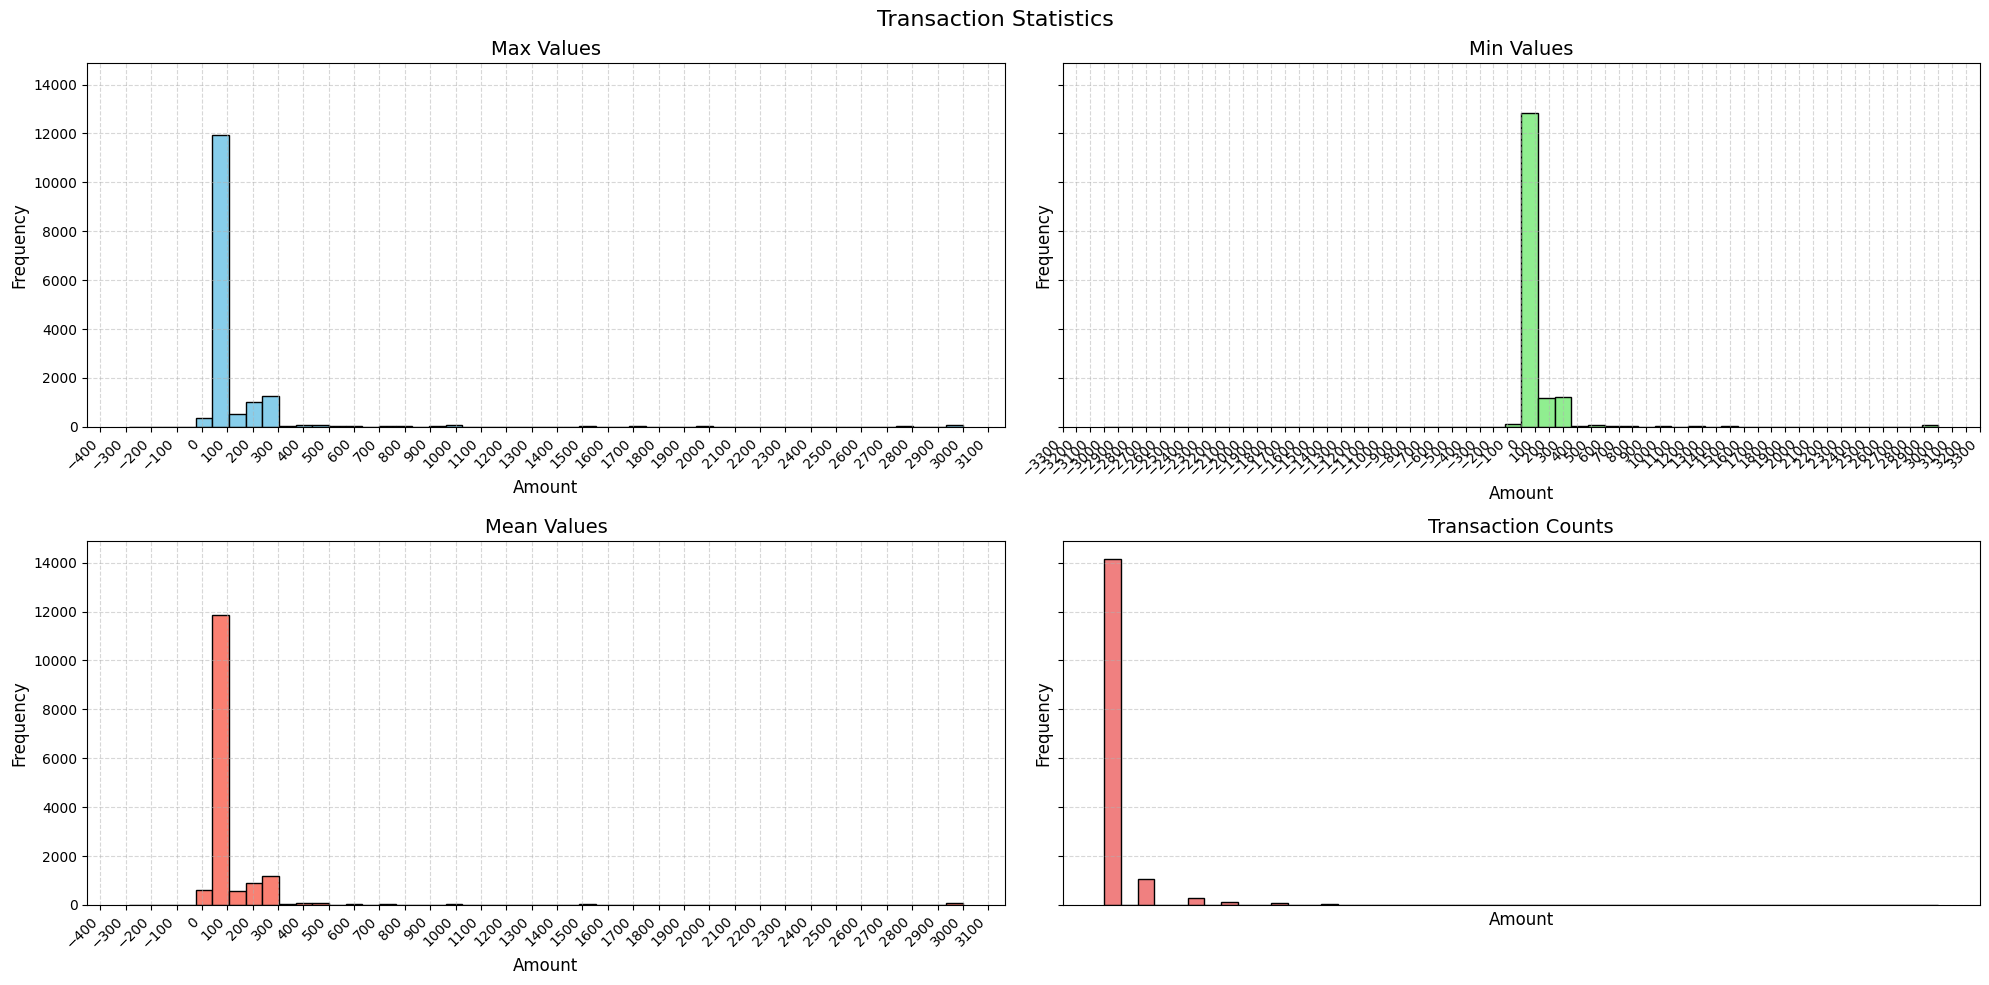

In [91]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Create a figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

# Plot histograms and set titles for each subplot
axs[0, 0].hist(users_df['max'], bins=50, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Max Values', fontsize=14)
axs[0, 0].set_xlabel('Amount', fontsize=12)
axs[0, 0].set_ylabel('Frequency', fontsize=12)
axs[0, 0].grid(True, linestyle='--', alpha=0.5)
axs[0, 0].xaxis.set_major_locator(MultipleLocator(100))
plt.setp(axs[0, 0].get_xticklabels(), rotation=45, ha='right')

axs[0, 1].hist(users_df['min'], bins=50, color='lightgreen', edgecolor='black')
axs[0, 1].set_title('Min Values', fontsize=14)
axs[0, 1].set_xlabel('Amount', fontsize=12)
axs[0, 1].set_ylabel('Frequency', fontsize=12)
axs[0, 1].grid(True, linestyle='--', alpha=0.5)
axs[0, 1].xaxis.set_major_locator(MultipleLocator(100))
plt.setp(axs[0, 1].get_xticklabels(), rotation=45, ha='right')

axs[1, 0].hist(users_df['mean'], bins=50, color='salmon', edgecolor='black')
axs[1, 0].set_title('Mean Values', fontsize=14)
axs[1, 0].set_xlabel('Amount', fontsize=12)
axs[1, 0].set_ylabel('Frequency', fontsize=12)
axs[1, 0].grid(True, linestyle='--', alpha=0.5)
axs[1, 0].xaxis.set_major_locator(MultipleLocator(100))
plt.setp(axs[1, 0].get_xticklabels(), rotation=45, ha='right')

axs[1, 1].hist(users_df['count'], bins=50, color='lightcoral', edgecolor='black')
axs[1, 1].set_title('Transaction Counts', fontsize=14)
axs[1, 1].set_xlabel('Amount', fontsize=12)
axs[1, 1].set_ylabel('Frequency', fontsize=12)
axs[1, 1].grid(True, linestyle='--', alpha=0.5)
axs[1, 1].xaxis.set_major_locator(MultipleLocator(100))
plt.setp(axs[1, 1].get_xticklabels(), rotation=45, ha='right')

# Overall title for the figure
plt.suptitle('Transaction Statistics', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()



The **histogram of transaction sums** reveals a pronounced concentration towards lower values, creating a right-skewed distribution. This implies that the majority of users tend to have low total transaction sums, while larger sums are infrequent among the user base.

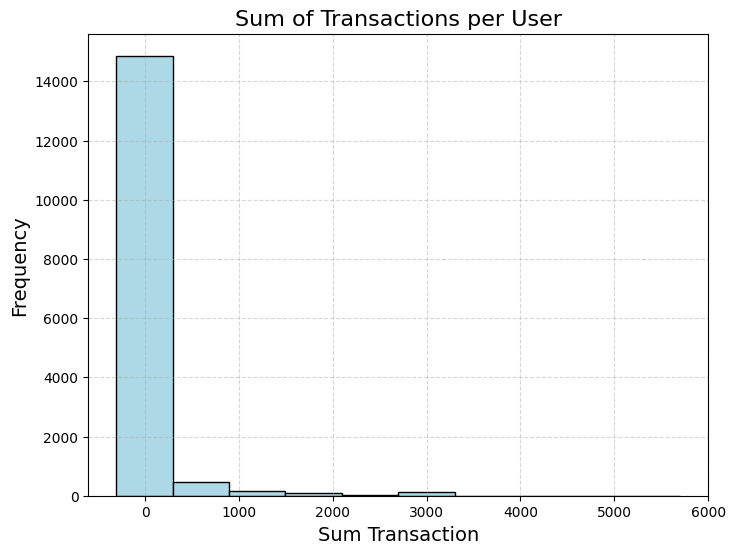

In [92]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram
ax.hist(users_df['sum'], color='lightblue', edgecolor='black')

# Set title and labels
ax.set_title('Sum of Transactions per User', fontsize=16)
ax.set_xlabel('Sum Transaction', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

# Add gridlines for better visualization
ax.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.show()


We can also find all the people who are in the giftcard dataset but not in transactions one. These users have not carried out a transaction in the period covered by the dataframe but they have purchased a giftcard.

In [93]:
gift_users = set(giftcard_23['client_email_hash'].unique())
trans_users = set(transaction_2023['email_hash'].unique())

not_trans_users = gift_users - trans_users
total_users = set(giftcard_23['client_email_hash']).union(set(transaction['email_hash']))

percent_not_trans = (len(not_trans_users) / len(total_users)) * 100

print(f"Percentage of users who purchased gift cards but didn't carry out any transactions: {percent_not_trans:.2f}%")


Percentage of users who purchased gift cards but didn't carry out any transactions: 4.73%


In [94]:
len(not_trans_users)

781

In conclusion we can assert that a big percentage of users make few transactions and these are of small amount as we can see from the average plot. Most of the users also make transactions with the same characteristics, since we have a large portion of individuals with the same max, min and sum amount of transactions. There are then 781 users (4.8% of the total)  who have not executed any transactions in the period covered by the data.

###Understanding distribution of giftcards

####Giftcard Distribution by Users

The distribution of gift cards is represented using data from the gift card model, grouped by users. We utilize various aggregate functions to consolidate the data on the number of gift cards purchased by each user:

1. Maximum
2. Average
3. Minimum
4. Count
5. Sum

In [53]:
giftcard_transactions = giftcard_23[['client_email_hash', 'amount']]
grouped_transactions = giftcard_transactions.groupby('client_email_hash', as_index=False)
transaction_features = pd.DataFrame()

Max

In [54]:
# Calculate the max, min, mean, count, and sum of the gift cards bought by every user
giftcard_max = grouped_transactions.max().reset_index()
transaction_features['max'] = giftcard_max['amount']

Min

In [55]:
# Calculate the min, mean, count, and sum of the gift cards bought by every user
giftcard_min = grouped_transactions.min().reset_index()
transaction_features['min'] = giftcard_min['amount']

Mean

In [56]:
giftcard_mean = grouped_transactions.mean().reset_index()
transaction_features['mean'] = giftcard_mean['amount']

Count of the giftcards bought by every user

In [57]:
giftcard_count = grouped_transactions.count().reset_index()
transaction_features['count'] = giftcard_count['amount']

Sum of the amounts of the giftcards bought by each user

In [58]:
giftcard_sum = grouped_transactions.sum().reset_index()
transaction_features['sum'] = giftcard_sum['amount']
transaction_features

,max,min,mean,count,sum
0,30,5,23.500000,10,235
1,30,30,30.000000,2,60
2,50,50,50.000000,1,50
3,30,30,30.000000,2,60
4,50,50,50.000000,1,50
...,...,...,...,...,...
7802,100,100,100.000000,2,200
7803,50,5,20.000000,3,60
7804,100,10,52.857143,7,370
7805,30,10,16.666667,3,50


To analyze the distribution of the giftcards per user we include in the transaction_features dataframe, created above, also the categories aggregated for users, using OneHotEncoder.

In [59]:
giftcard_23[['category']].category.unique()

array(['sport', 'food', 'abbigliamento', 'casa', 'carburanti',
       'elettronica', 'ecommerce', 'brico', 'gaming'], dtype=object)

In [60]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(giftcard_23[['category']])

# Create a DataFrame with the one-hot encoded columns
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())
# Add the client_email_hash to the dataframe
one_hot_df = pd.concat([giftcard_23['client_email_hash'], one_hot_df], axis=1)

# Group the data in the dataframe based on the email_hash and sum the rows
one_hot_df = one_hot_df.groupby('client_email_hash', as_index=False).sum().reset_index()

transaction_features = pd.concat([one_hot_df, transaction_features], axis=1)

The giftcard data does not include users who haven't purchased a gift card in December. Although we lack a dataset with all registered GoWelfare platform users, we can identify individuals present in the transaction dataset but not in giftcard. These users haven't bought a gift card during the dataframe's covered period but have conducted a transaction. We append these users to the new_feature dataframe to analyze the distribution, incorporating this user category.

In [61]:
# Create a set of unique client email hashes from the 'giftcard' dataset
gift_hashes = set(giftcard_23['client_email_hash'].unique())

# Create a set of unique client email hashes from the 'transaction' dataset
trans_hashes = set(transaction['email_hash'].unique())

# Identify the client email hashes present in 'transaction' but not in 'giftcard'
missing_hashes = trans_hashes - gift_hashes

# Create default row values for missing hashes
default_row = {
    'category_abbigliamento': 0,
    'category_brico': 0,
    'category_carburanti': 0,
    'category_casa': 0,
    'category_ecommerce': 0,
    'category_elettronica': 0,
    'category_food': 0,
    'category_gaming': 0,
    'category_sport': 0,
    'max': 0,
    'min': 0,
    'mean': 0,
    'count': 0,
    'sum': 0
}

# Create a DataFrame with default rows for missing hashes
new_rows = pd.DataFrame([{'client_email_hash': hash_val, **default_row} for hash_val in missing_hashes])

# Concatenate the default rows with existing 'transaction_features'
new_transaction_features = pd.concat([transaction_features, new_rows], ignore_index=True)

In [62]:
new_transaction_features.describe()

,index,category_abbigliamento,category_brico,category_carburanti,category_casa,category_ecommerce,category_elettronica,category_food,category_gaming,category_sport,max,min,mean,count,sum
count,7807.000000,16514.000000,16514.000000,16514.000000,16514.000000,16514.000000,16514.000000,16514.000000,16514.000000,16514.000000,16514.000000,16514.000000,16514.000000,16514.000000,16514.000000
mean,3903.000000,0.039058,0.000182,0.233923,0.078237,0.277219,0.089984,0.893363,0.011869,0.121412,25.183178,13.573029,18.459226,1.745246,60.679121
std,2253.831109,0.318185,0.017400,1.131658,0.449127,0.864491,0.588464,3.081536,0.197126,0.737994,33.180369,23.742011,26.437695,3.877142,145.157957
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1951.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3903.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5854.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,20.000000,30.000000,3.000000,60.000000
max,7806.000000,12.000000,2.000000,57.000000,12.000000,8.000000,14.000000,120.000000,12.000000,53.000000,150.000000,150.000000,150.000000,139.000000,3000.000000


In [63]:
new_transaction_features.head()

,index,client_email_hash,category_abbigliamento,category_brico,category_carburanti,category_casa,category_ecommerce,category_elettronica,category_food,category_gaming,category_sport,max,min,mean,count,sum
0,0.0,0001ae17f683bd4edaa367cfb15c7195b3da09fe637b7a...,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,30,5,23.5,10,235
1,1.0,00047a986c11ab2321be9d698dd192e94414f194f8f227...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,30,30,30.0,2,60
2,2.0,001496ca4ad5641fa7c4292967cd3da9316a35e7735ed4...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,50,50,50.0,1,50
3,3.0,0029cb95812f85a66c49e0e790d341074b39adebe39332...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,30,30,30.0,2,60
4,4.0,002a1fd089f09df4c57194cdbdb6a4faf0a82e0a90e542...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50,50,50.0,1,50


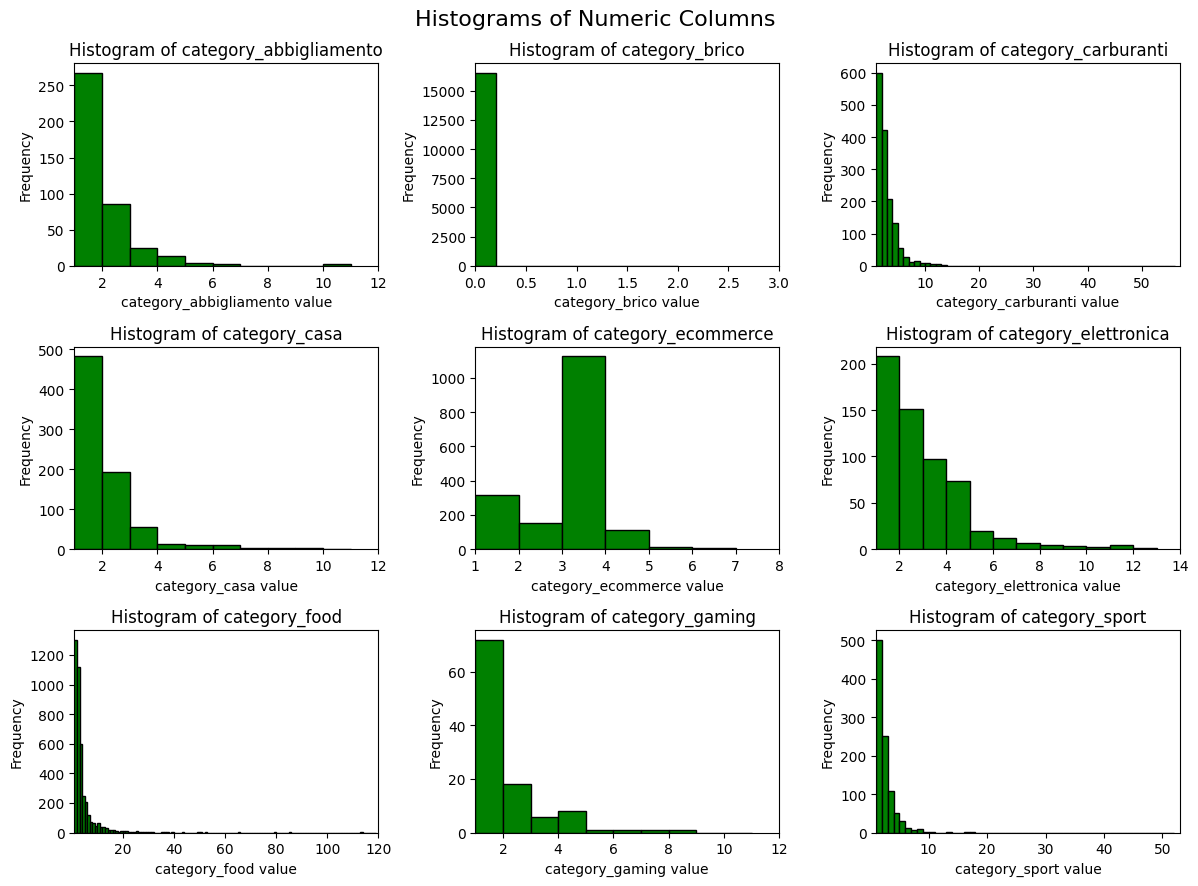

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure and an array of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 9))

# Flatten the axes array
axes = axes.ravel()

# Plot each numeric column with a histogram on the respective subplot
numeric_columns = new_transaction_features.select_dtypes(include=[np.number]).columns[1:10]
for i, col in enumerate(numeric_columns):
    if col == 'category_brico':
        axes[i].hist(new_transaction_features[col], color='green', edgecolor='black')
        axes[i].set(title=f'Histogram of {col}', xlim=(0, max(new_transaction_features[col]) + 1), xlabel=f'{col} value', ylabel='Frequency')
    else:
        axes[i].hist(new_transaction_features[col], color='green', edgecolor='black', bins=list(range(1, int(max(new_transaction_features[col])))))
        axes[i].set(title=f'Histogram of {col}', xlim=(1, max(new_transaction_features[col])), xlabel=f'{col} value', ylabel='Frequency')

# Add a title for the entire figure
fig.suptitle('Histograms of Numeric Columns', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

From the above histograms we want to analyse how many users have bought a specific amount of that determined category of giftcard.
* **Category_abbigliamento**: in range 1-9 with the 1 as the most usual frequency. The maximum number of giftcards bought from this category by a single user is 9;

* **Category_brico**: the least bought category, in fact we can't see any bar in the graph different from zero.

* **Category_carburanti**: in range 1-65 with the 1 as the most usual frequency. The maximum number of giftcards bought from this category by a single user is 65;

* **Category_casa**: in range 1-10 with the 1 as the most usual frequency. The maximum number of giftcards bought from this category by a single user is 10;

* **Category_ecommerce**: in range 1-80 with the 1 as the most usual frequency.The maximum number of giftcards bought from this category by a single user is 80;

* **Category_elettronica**: in range 1-25 with the 1 as the most usual frequency. The maximum number of giftcards bought from this category by a single user is 25;

* **Category_food**: the most bought category by users as we can see from y-axis of the plot have been bought 1 single time for more than 1750 users. It's also the category with the maximum number of giftcards purchased by a single user with 93 acquisition.

* **Category_gaming**: in range 1-17 with the 1 as the most usual frequency. The maximum number of giftcards bought from this category by a single user is 17;

* **Category_sport**: in range 1-30 with the 1 as the most usual frequency. The maximum number of giftcards bought from this category by a single user is 30;

####Histogram for the statistics

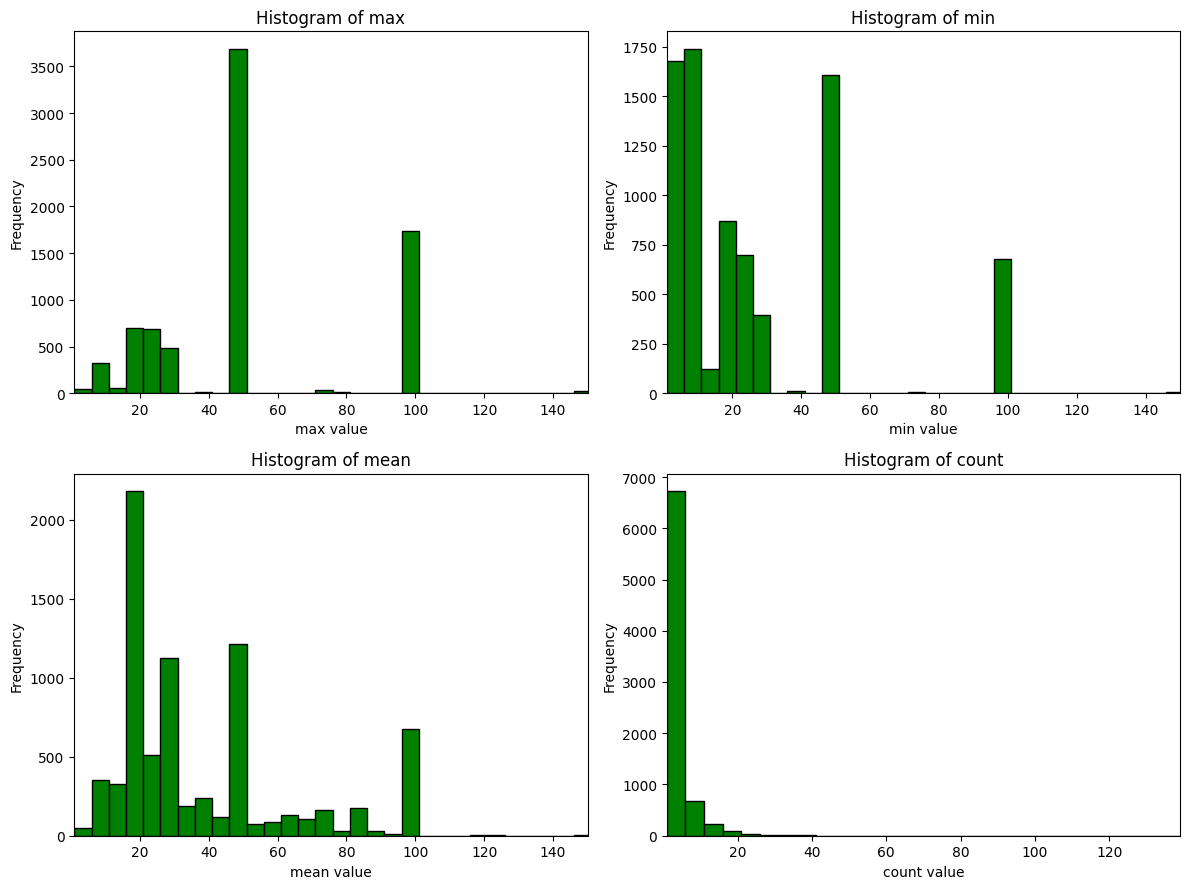

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Select only the columns you want to plot
columns_to_plot = new_transaction_features.columns[11:-1]

# Calculate the number of rows and columns for the subplots
num_plots = len(columns_to_plot)
num_cols = 2
num_rows = int(np.ceil(num_plots / num_cols))

# Create a figure and an array of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9))

# Flatten the axes array if it's 2D, to simplify indexing
axes = axes.flatten()

# Plot each column with a histogram on the respective subplot
for i, col in enumerate(columns_to_plot):
    axes[i].hist(new_transaction_features[col], color='green', edgecolor='black', bins=list(range(1, 170, 5)))
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlim(1, max(new_transaction_features[col]))  # Set the x-axis range for each subplot
    axes[i].set_xlabel(f'{col} value')  # Set the x-axis label for each subplot
    axes[i].set_ylabel('Frequency')  # Optionally, you can also set the y-axis label

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


The histograms allow us to visualize the distribution of gift card values across different aggregation functions for users: maximum, minimum, mean, and count of gift cards.

- **Histogram of Max Values**: This histogram shows that most users' highest purchase amount of gift cards is between 40 and 60, with over 4000 users buying gift cards in this range.

- **Histogram of Min Values**: The histogram for minimum values is heavily skewed towards zero or low amounts, indicating that many users have purchased only small-value gift cards.

- **Histogram of Mean Values**: This histogram represents the average gift card amount per user. Similar to the minimum values, most users have a low average value, with the frequency quickly decreasing as the average value increases, peaking at 100, which is also a common value for maximum and minimum.

- **Histogram of Gift Card Counts**: The distribution of gift card counts per user is right-skewed. Most users have purchased a low number of gift cards, with very few users buying more than 20.

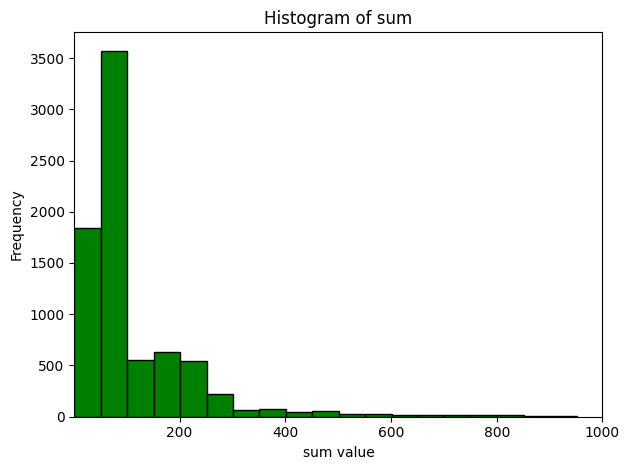

In [66]:
fig, ax = plt.subplots()
ax.hist(new_transaction_features['sum'], color='green', edgecolor='black', bins = list(range(1,1000,50)))
ax.set_title('Histogram of sum')
ax.set_xlim(1, 1000)  # Set the x-axis range for the plot
ax.set_xlabel('sum value')  # Set the x-axis label for each subplot
ax.set_ylabel('Frequency')  # Optionally, you can also set the y-axis label
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

**Histogram of Gift Card Sums**: The majority of gift card amounts are low, ranging between 1 and 100, resulting in a right-skewed distribution. As anticipated, there is a peak around 100, indicating that many users have purchased a single gift card worth 100.

##Compute and report similarity between users in terms type/used gift cards

The similarity between the users based on the giftcards bought is elaborated in this section with two different methodologies. The cluster part is useful to see groups in which we can separate the individuals to understand the affinity. Another measure taken in consideration is the Cosine Similarity to measure the pairwise similarity between users in terms of their giftcard purchasing patterns.  Together, clustering and cosine similarity offer a dual perspective: clustering provides a macro-view to segment the user base, while cosine similarity affords a micro-view into individual user relationships.

###Cluster

Clustering is an unsupervised machine learning technique that helps identify larger patterns in our data by segmenting users into meaningful groups. Through cluster analysis, we've defined distinct segments of users with similar buying behaviors. Since the users are clustered based on gift card purchasing patterns, we use the dataframe with all values aggregated by user.

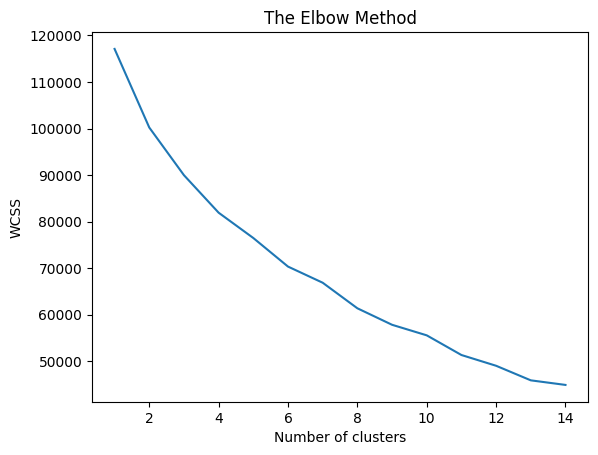

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Initialize the scaler
scaler = StandardScaler()

# Ensure all column names are strings
transaction_features.columns = transaction_features.columns.astype(str)

# Select only numeric columns for scaling, excluding 'client_email_hash'
numeric_columns = transaction_features.select_dtypes(include=[np.number]).columns
scaled_features = scaler.fit_transform(transaction_features[numeric_columns])

# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the elbow method results
plt.plot(range(1, 15), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The Elbow method is useful to decide the right number of clusters that is appropriate to choose in order to create well-separeted clusters but with an opportune amount of users in each of them. Higher the number of the clusters lower the quantity of individuals in each of these. By visual inspection of the graph above we understand that the number which could be a good fit for our case is 3.

In [68]:
number_clusters = 3

# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = number_clusters, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(scaled_features)

In [69]:
#Creating a new dataframe that comprehends the 'client_email_hash' and the clusters of each user
df_cl = pd.DataFrame()
df_cl['client_email_hash'] = transaction_features['client_email_hash']
df_cl['cluster'] = y_kmeans

# Calculate the count of points in each cluster
cluster_counts = df_cl['cluster'].value_counts()

# Calculate the total number of points
total_points = len(df_cl)

# Calculate the proportion of points in each cluster
cluster_proportions = cluster_counts / total_points

# Convert the series to a DataFrame for easy viewing
proportions_df = pd.DataFrame(cluster_proportions).reset_index()
proportions_df.columns = ['Cluster', 'Proportion']
proportions_df = proportions_df.sort_values('Cluster').reset_index(drop = True) #sort the dataframe based on the Cluster number
proportions_df['Count'] = cluster_counts #add the number of users for each cluster

# Display the DataFrame as a table
proportions_df


,Cluster,Proportion,Count
0,0,0.787498,6148
1,1,0.194569,1519
2,2,0.017933,140


### Proportion of Users in Each Cluster

To analyze the clusters, we first look at the proportion of total users in each cluster. From three clusters onward, we observe that one cluster contains only three users, which influenced our decision to choose three clusters. A cluster with only three individuals is not very useful.

The results show significantly unbalanced groups: Cluster 0 contains about 78% of the users, while Cluster 1 has only about 3%. To reduce the proportion of users in Cluster 0, we considered using five clusters. However, the average silhouette score for five clusters was 0.34144819886301914, which is lower than the score for three clusters, contrary to our expectations.

**This analysis reveals a large group of users with similar behaviors and two smaller groups. These results align with our previous analysis of the gift card distribution.**

The average silhouette_score is : 0.3229693773111693


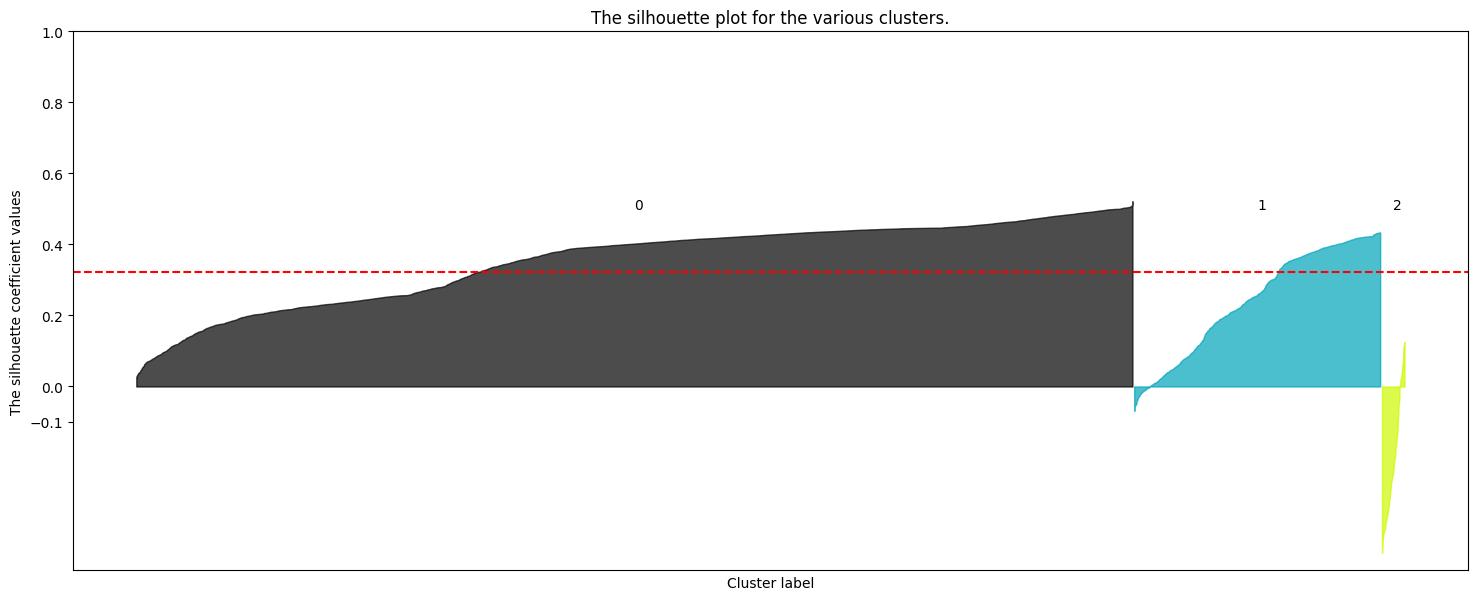

In [70]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

silhouette_avg = silhouette_score(scaled_features, y_kmeans)  # Calculating the average silhouette score
print(f"The average silhouette_score is : {silhouette_avg}")  # Printing the average silhouette score

sample_silhouette_values = silhouette_samples(scaled_features, y_kmeans)  # Computing silhouette scores for each sample

fig, ax = plt.subplots()  # Creating a plot
fig.set_size_inches(18, 7)  # Setting plot size

x_lower = 10  # Initializing lower limit of x-axis for plotting

for i in range(number_clusters):  # Looping through each cluster
    ith_cluster_silhouette_values = sample_silhouette_values[y_kmeans == i]  # Getting silhouette values for current cluster
    ith_cluster_silhouette_values.sort()  # Sorting silhouette values

    size_cluster_i = ith_cluster_silhouette_values.shape[0]  # Getting size of current cluster
    x_upper = x_lower + size_cluster_i  # Calculating upper limit of x-axis for current cluster

    color = cm.nipy_spectral(float(i) / number_clusters)  # Assigning color for current cluster
    ax.fill_between(np.arange(x_lower, x_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)  # Filling area under curve for current cluster

    ax.text(x_lower + 0.5 * size_cluster_i, 0.5, str(i))  # Labeling silhouette plots with cluster numbers
    x_lower = x_upper + 10  # Updating lower limit of x-axis for next plot

ax.set_title("The silhouette plot for the various clusters.")  # Setting title of the plot
ax.set_xlabel("Cluster label")  # Setting x-axis label
ax.set_ylabel("The silhouette coefficient values")  # Setting y-axis label

ax.axhline(y=silhouette_avg, color="red", linestyle="--")  # Adding a horizontal line for average silhouette score
ax.set_xticks([])  # Clearing x-axis labels
ax.set_yticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])  # Setting y-axis ticks

plt.show()  # Displaying the plot

The silhouette plot shows the silhouette scores for the three different clusters. A silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. The average silhouette score is marked by the red dashed line and it is also written above the plot.
Cluster 0 and Cluster 1 have silhouette scores mostly above the average, indicating good cluster cohesion and separation for these groups.
Cluster 2 has a wide range of silhouette scores, including many that are negative, which indicates that some points in this cluster may be wrongly assigned.
Overall, the plot indicates that while Clusters 0 and 1 seem to be reasonably well-defined, Cluster 2 might not be as cohesive as the others.


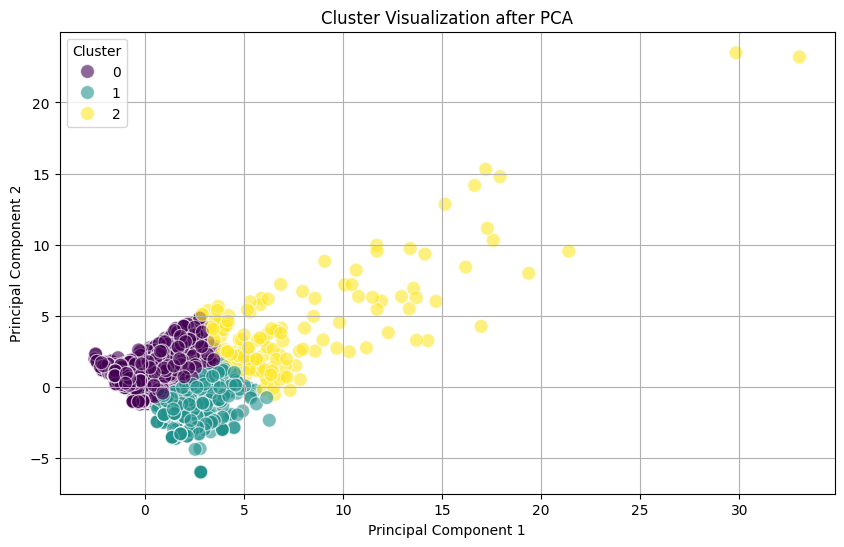

In [71]:
from sklearn.decomposition import PCA

# Reduce dimensions
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a new DataFrame for plotting
plot_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
plot_df['Cluster'] = y_kmeans  # Add the cluster labels

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Cluster', data=plot_df, palette='viridis', s=100, alpha=0.6)
plt.title('Cluster Visualization after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

The clusters have been analyzed to understand how much they are able to group points, that are actually close, into the same cluster. This subsequent section tries to evaluate the clusters through visual inspection. The feature on which the clusters were trained have more than two dimensions, so the PCA is used to reduce the high-dimensional feature space to just two dimensions. This is helpful for the visualization of the multi-dimensional clustering results.
Each cluster will be colored differently to be distinguishable.
This visualization will help into understanding how well the clustering has performed in terms of data separation.

In [72]:
# Data Exploration
for cluster_id in range(number_clusters):
    cluster_data = transaction_features[df_cl['cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(cluster_data.describe())
    print("\n")


Cluster 0:
             index  category_abbigliamento  category_brico  \
count  6148.000000             6148.000000          6148.0   
mean   3909.573195                0.059206             0.0   
std    2252.971932                0.316677             0.0   
min       0.000000                0.000000             0.0   
25%    1950.750000                0.000000             0.0   
50%    3921.500000                0.000000             0.0   
75%    5851.250000                0.000000             0.0   
max    7806.000000                4.000000             0.0   

       category_carburanti  category_casa  category_ecommerce  \
count          6148.000000    6148.000000         6148.000000   
mean              0.491705       0.140696            0.732596   
std               1.307994       0.513570            1.283119   
min               0.000000       0.000000            0.000000   
25%               0.000000       0.000000            0.000000   
50%               0.000000       0.00000

Let's extract some insights from this data:

1. **Cluster Size and Distribution**:
   - Cluster 0: Contains 6148 users.
   - Cluster 1: Contains 1519 users.
   - Cluster 2: Contains 140 users.
   - These clusters exhibit different sizes, with Cluster 0 being the largest and Cluster 2 being the smallest. Such disparities in cluster sizes could indicate varying levels of user engagement or activity.

2. **Category Preferences**:
   - Users in each cluster exhibit different preferences for product categories, as indicated by mean values.
   - Cluster 2: Users in this cluster show a higher mean purchase count across categories like food, e-commerce, and electronics compared to other clusters. They also have a higher maximum purchase count.
   - Cluster 0: Users in this cluster have lower mean purchase counts across all categories compared to Cluster 1 and Cluster 2. Their maximum purchase counts are also lower.
   - Cluster 1: Users in this cluster show a moderate mean purchase count across categories, with slightly higher counts in categories like e-commerce and food compared to Cluster 0. They have a higher maximum purchase count compared to Cluster 0 but lower compared to Cluster 2.

3. **Transaction Statistics**:
   - Users in each cluster have different transaction statistics, such as mean, minimum, maximum, and count.
   - For example, users in Cluster 2 have a higher mean transaction value compared to other clusters, indicating potentially higher spending behavior.

4. **Observations**:
   - Cluster 2 seems to represent heavy spenders or frequent buyers, as they have higher mean and maximum transaction values across various categories.
   - Cluster 0 represents users with lower engagement, as they have lower mean and maximum transaction values across all categories.
   - Cluster 1 falls between the other two clusters in terms of transaction values, indicating moderate engagement.


##Identify potential anomalies in the users

To identify anomalies in users, we introduce the concept of outliers. An outlier is an observation in the dataset (in this case, a user) with values significantly distant from the "normal values" of other observations. These outliers indicate anomalies compared to the typical user characteristics.

To detect potential outliers, we've developed a custom function from scratch based on the interquartile range (IQR) statistical tool. We define an outlier as any user with at least two values in our dataframe falling outside the 10th and 90th percentiles, with an "InterquaNtile" factor of 2. This approach provides more meaningful results compared to using standard quartiles, where most rows are classified as outliers.

We'll apply this outlier detection to two main datasets:
- The transaction dataset, where outliers pertain to interactions with the platform for credit charging.
- The gift card dataset, where outliers relate to gift card purchases.

###Outliers of Users Transaction Dataset

We find the users that have an anomalous interaction with the platform in order to charge the credit

In [73]:
users_df

,index,receiver_id_hash,max,min,mean,sum,count
0,0,0004bf23b4f1cc4c4cd3f64336858400ea4f3593c63b4d...,150.00,150.00,150.00,150.00,1
1,1,00055e86e2ba47a5faeca682e9810825a4eb1db61c6f41...,60.00,60.00,60.00,60.00,1
2,2,000be7602b63bbc057f42abc9da89df5036a8b1a74d3f5...,60.00,60.00,60.00,60.00,1
3,3,000c1f4cb1dfcf744d61ddda5b3fe8bd48690dc42e9434...,60.00,60.00,60.00,60.00,1
4,4,00138923e49b2777cf836d98b56c447ff2448eb0da3a11...,100.00,100.00,100.00,100.00,1
...,...,...,...,...,...,...,...
15730,15730,ffe1e6952c9f05c5fd155c025fa7b12fb543cc269a1f0f...,100.00,20.00,50.00,150.00,3
15731,15731,ffe62e8cab00358fd33437c301d944326a3a788ca19364...,600.00,200.00,400.00,800.00,2
15732,15732,ffeb6333f8a0a47c036a64e36997ee8a84066eb2e0ab2f...,122.71,122.71,122.71,122.71,1
15733,15733,ffec1afd3bf62c1131cc4d2509ce0e40b962fb33f9c103...,60.00,60.00,60.00,60.00,1


In [74]:
transaction_outliers = []
real_transaction_outliers = []

for col in users_df.columns[2:]:
    first_quartile = scipy.stats.iqr(users_df[col],rng=(0, 5))
    third_quartile = scipy.stats.iqr(users_df[col],rng=(0, 95))
    iqr = scipy.stats.iqr(users_df[col],rng=(5, 95))
    lower = first_quartile - 2 * iqr #define the lower bound interval for normal values
    upper = third_quartile + 2 * iqr #define the upper bound interval for normal values
    for idx, row in users_df.iterrows(): #start the iterations on rows
        if users_df.iloc[idx][col] < lower or users_df.iloc[idx][col] > upper: #check if the values is inside the range admitted
            if users_df.iloc[idx]['receiver_id_hash'] not in transaction_outliers:
                transaction_outliers.append(users_df.iloc[idx]['receiver_id_hash']) #append to the outliers list the first time we find an anomalies
            elif users_df.iloc[idx]['receiver_id_hash'] not in real_transaction_outliers:
                real_transaction_outliers.append(users_df.iloc[idx]['receiver_id_hash']) #append to the final outliers list if the anomalies are more than one

len(real_transaction_outliers)

572

This code iterates through each column of the dataset, calculating the interquartile range (IQR) with modified percentiles (5th and 95th) to reduce outlier sensitivity. It then defines upper and lower bounds based on these modified IQRs. For each data point, if it falls outside these bounds, it's flagged as an outlier and added to a list. To minimize false positives, it ensures unique identifiers are stored in two lists, with the second list being more stringent. Finally, it counts the number of unique identifiers in the stricter outlier list.

With this strategy we found 572 outliers out of more than 15000 different  receivers.

Summary Statistics for Outliers:
              index          max         min         mean          sum  \
count    572.000000   572.000000   572.00000   572.000000   572.000000   
mean    7519.774476  1180.688497   715.11021   927.548016  1393.101626   
std     4613.395004  1054.591418  1071.67721   985.179702  1050.972565   
min       36.000000  -288.000000 -3000.00000  -288.000000  -308.230000   
25%     3407.000000   150.000000    20.00000    75.000000   374.500000   
50%     7329.500000  1000.000000   100.00000   600.000000  1200.000000   
75%    11688.750000  2000.000000  1200.00000  1499.913750  2256.500000   
max    15726.000000  3000.000000  3000.00000  3000.000000  5700.000000   

            count  
count  572.000000  
mean     3.185315  
std      2.338424  
min      1.000000  
25%      1.000000  
50%      3.000000  
75%      4.000000  
max     20.000000  


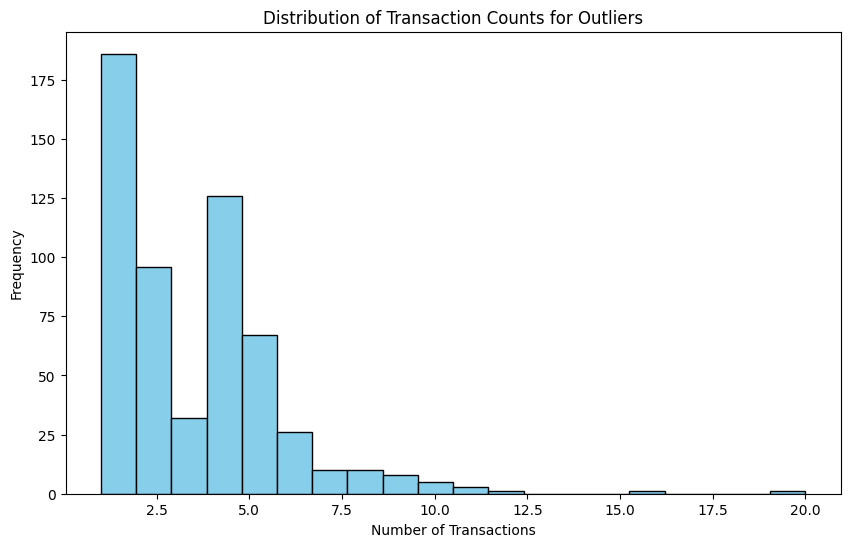

In [75]:
# Assuming you have already detected outliers and have a list named real_transaction_outliers containing the receiver_id_hash of outliers

# Filter the DataFrame to include only outlier data
outliers_df = users_df[users_df['receiver_id_hash'].isin(real_transaction_outliers)]

# Print summary statistics for outliers
print("Summary Statistics for Outliers:")
print(outliers_df.describe())


# Frequency of Transactions
# Visualize the distribution of transaction counts for outliers
plt.figure(figsize=(10, 6))
plt.hist(outliers_df['count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Transaction Counts for Outliers')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.show()

Comparing the statistics of the majority cluster with those of the outliers reveals intriguing insights into user behavior:

1. **Size Disparity**:
   
   - The majority cluster consists of 6148 users, representing the typical user base, while outliers comprise only 572 users. Despite their smaller size, outliers constitute a distinct subset warranting attention due to their deviant behavior.

2. **Transaction Amounts**:

   - The mean transaction amount in the majority cluster is relatively moderate, suggesting typical spending behavior among most users. In contrast, outliers exhibit significantly higher mean transaction amounts, indicating potential high-value transactions or irregular spending patterns.


4. **Transaction Range**:

   - The transaction range within the majority cluster is relatively consistent, indicating uniform spending habits among most users. Conversely, outliers display a broader range of transaction values, suggesting diverse spending behaviors within this group, ranging from minimal to substantial spending.

5. **Summary Statistics Comparison**:

   - Outliers exhibit notable disparities in summary statistics compared to the majority cluster, including higher maximum transaction amounts, lower minimum transaction amounts (some even negative), higher mean transaction amounts, and a wider range of transaction counts. These differences signify distinct spending behaviors or anomalies within the user base.



# Challenge 3

After the results of the analysis, the board of directors sends you a final email: for December
2024, we would like to optimize the set of brands and giftcards values available (hiding the
worst performing ones), in order to maximize our total EBITDA.
- Define, for each day of Dec 2024, which giftcards should be available in GOWelfare;
- Send us an excel file with the set of giftcars (just the giftcard_model_id) that should
appear inside the app;
- Send us a short text explaining the reasons behind your choice;
- Don’t reduce the offer too much! Or people will not spend;
- EBITDA != turnover.

In [76]:
# Extract the day from the datetime column
giftcard_23['day'] = giftcard_23['purchase_date'].dt.day
giftcard_23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype                    
---  ------                 --------------  -----                    
 0   id                     28821 non-null  int64                    
 1   provider_error_code    28821 non-null  object                   
 2   purchase_date          28821 non-null  datetime64[ns, UTC+01:00]
 3   giftcard_model_id      28821 non-null  int64                    
 4   transaction_uuid_hash  28821 non-null  object                   
 5   client_email_hash      28821 non-null  object                   
 6   amount                 28821 non-null  int64                    
 7   new_brand_name         28821 non-null  object                   
 8   brand_id               28821 non-null  int64                    
 9   category               28821 non-null  object                   
 10  fee                    28821 non-null  float64

In [77]:
giftcard_23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype                    
---  ------                 --------------  -----                    
 0   id                     28821 non-null  int64                    
 1   provider_error_code    28821 non-null  object                   
 2   purchase_date          28821 non-null  datetime64[ns, UTC+01:00]
 3   giftcard_model_id      28821 non-null  int64                    
 4   transaction_uuid_hash  28821 non-null  object                   
 5   client_email_hash      28821 non-null  object                   
 6   amount                 28821 non-null  int64                    
 7   new_brand_name         28821 non-null  object                   
 8   brand_id               28821 non-null  int64                    
 9   category               28821 non-null  object                   
 10  fee                    28821 non-null  float64

In [78]:
day_count = giftcard_23['day'].value_counts()
day_count = day_count.sort_index(ascending=True)

# Display the results
print(day_count)

day
1      536
2      599
3      312
4      394
5      336
6      532
7      524
8      694
9      527
10     346
11     432
12    1631
13    1475
14    1108
15    1312
16    1360
17    1053
18    1168
19    1191
20    1371
21    1237
22    1239
23    1307
24     733
25     172
26     403
27    1641
28    1325
29    1669
30    1278
31     916
Name: count, dtype: int64


In [79]:
# Group by 'day' and 'giftcard_model_id' and sum the 'profit' column
daily_profit = giftcard_23.groupby(['day', 'giftcard_model_id'])['profit'].sum().reset_index()

# Rename columns for better readability
daily_profit.columns = ['day', 'giftcard_model_id', 'total_profit']

# Display the results
print(daily_profit)


      day  giftcard_model_id  total_profit
0       1                  1          2.80
1       1                  2         12.00
2       1                  3         32.00
3       1                  4         92.00
4       1                  5          0.06
...   ...                ...           ...
2114   31                106         12.80
2115   31                107          0.75
2116   31                108          5.50
2117   31                109          1.50
2118   31                110          1.35

[2119 rows x 3 columns]


In [80]:

# Step 1: Group by 'day' and 'giftcard_model_id' and sum the 'profit' column
daily_profit = giftcard_23.groupby(['day', 'giftcard_model_id'])['profit'].sum().reset_index()

# Rename columns for better readability
daily_profit.columns = ['day', 'giftcard_model_id', 'total_profit']

# Step 2: Calculate the total profit per day
total_daily_profit = daily_profit.groupby('day')['total_profit'].sum().reset_index()

# Rename columns for better readability
total_daily_profit.columns = ['day', 'daily_total_profit']

# Step 3: Merge the total daily profit with the daily profit per gift card model
merged_profit = pd.merge(daily_profit, total_daily_profit, on='day')

# Step 4: Calculate the percentage of the total profit for each gift card model
merged_profit['percentage_of_daily_total'] = (merged_profit['total_profit'] / merged_profit['daily_total_profit']) * 100

# Display the results
print(merged_profit)


      day  giftcard_model_id  total_profit  daily_total_profit  \
0       1                  1          2.80             495.385   
1       1                  2         12.00             495.385   
2       1                  3         32.00             495.385   
3       1                  4         92.00             495.385   
4       1                  5          0.06             495.385   
...   ...                ...           ...                 ...   
2114   31                106         12.80            1122.080   
2115   31                107          0.75            1122.080   
2116   31                108          5.50            1122.080   
2117   31                109          1.50            1122.080   
2118   31                110          1.35            1122.080   

      percentage_of_daily_total  
0                      0.565217  
1                      2.422358  
2                      6.459622  
3                     18.571414  
4                      0.012112  
...

In [81]:
# Filter data for December 2024
december_data = giftcard_23[(giftcard_23['purchase_date'].dt.year == 2023) & (giftcard_23['purchase_date'].dt.month == 12)]

# Create a DataFrame to hold the daily selection
days_in_december = pd.date_range(start="2023-12-01", end="2023-12-31", freq='D')
daily_selection = pd.DataFrame(index=days_in_december, columns=['giftcard_model_ids'])

# For each day in December 2024
for day in days_in_december:
    # Filter data for the current day
    daily_data = december_data[december_data['purchase_date'].dt.date == day.date()]

    # Group by giftcard_model_id to aggregate the profit for the day
    daily_performance = daily_data.groupby('giftcard_model_id')['profit'].sum().sort_values(ascending=False)

    # Calculate the threshold profit for the day (80% of total daily profit)
    total_daily_profit = daily_performance.sum()
    threshold_profit = 0.8 * total_daily_profit

    # Select gift cards until we reach the threshold for the day
    cumulative_profit = daily_performance.cumsum()
    selected_giftcards = cumulative_profit[cumulative_profit <= threshold_profit].index.tolist()

    # Ensure every category is included for the day
    all_categories = daily_data['category'].unique()
    selected_categories = daily_data[daily_data['giftcard_model_id'].isin(selected_giftcards)]['category'].unique()
    missing_categories = set(all_categories) - set(selected_categories)

    for category in missing_categories:
        highest_profit_giftcard = daily_data[daily_data['category'] == category].groupby('giftcard_model_id')['profit'].sum().idxmax()
        selected_giftcards.append(highest_profit_giftcard)

    # Store the selected gift cards for the day
    daily_selection.at[day, 'giftcard_model_ids'] = selected_giftcards

# Export the daily selection to Excel
daily_selection.to_excel('elected_giftcards_dec_2024.xlsx', index=True)

### Explanation

1. **Profit Maximization**: Select the top-performing gift cards based on profit, ensuring to capture at least 80% of the total profit for each day.
2. **Category Inclusion**: Check if any categories are missing in the selected gift cards. For each missing category, add the highest-profit gift card from that category to the selection.
3. **Balanced Offering**: This approach ensures a diverse and profitable set of gift cards, balancing profit maximization with a broad offering to attract a wide range of customers.

This code will generate an Excel file with the selected gift card IDs, ensuring no categories are excluded and maximizing profit. Adjust any parameters as needed based on specific insights or requirements from the board of directors.